### Andrej here Countiou building the makemore and he implement this [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) but we will work on characters level gives 3 characters and predict the forth while in the paper workes on word level using data set of 170000 word, 
- Here we will work on data set of 32000 name


In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-12-03 20:36:01--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2022-12-03 20:36:01 (50.6 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
itos[5]

'e'

# Building our training **datase**

In [58]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size                    #padded context of just zeros tokens
  for ch in w + '.':
    ix = stoi[ch]                               #get the ch in the sequance
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append, [0,0,0] ---> [0,0,5], just remove the first element and took
                                                                           # the last 2 and add the new ix to it 
X = torch.tensor(X)
Y = torch.tensor(Y)


In [59]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [9]:
Y

tensor([ 5, 13, 13,  1,  0])

# Implementing the embedding lookup table
- we have 27 possible char and we are going to empedd them in lower dimensional space, we will start with two_dim space, so we will start by random numbers (27, 2), so each one of the of the 27 char will have two dimensioal empedding 
(while in the paper we have 27000 word and they embedd them into 30 lower dimesnional space).

In [10]:
C = torch.randn(27, 2)

In [11]:
C

tensor([[-1.0522,  0.2530],
        [-0.1251, -1.2474],
        [-1.7475,  0.1838],
        [ 0.4970, -1.3689],
        [-1.1218, -0.6679],
        [-0.1889,  1.5595],
        [ 0.9180, -0.8033],
        [-1.2013, -0.2322],
        [ 0.4124, -0.2365],
        [ 1.8675,  1.0540],
        [ 0.6034, -0.6710],
        [ 0.0872, -0.7608],
        [-0.5289, -0.4357],
        [-0.8474, -0.2539],
        [-1.0801,  0.2615],
        [ 1.4573, -0.1292],
        [-0.0157, -1.3866],
        [ 0.4416,  0.6302],
        [ 0.8431,  0.9441],
        [ 0.3021,  0.4908],
        [ 1.0601, -0.6856],
        [-0.1656,  0.0749],
        [ 0.7490, -0.0637],
        [ 1.3321,  0.3053],
        [-0.3365, -1.4840],
        [ 0.7814, -1.2887],
        [-1.2712,  0.6568]])

# Embedd the numbers inside the input x
we want to embedd all the numbers inside the input x using lookup table c there is two ways:
- C[5] so simply it will gives you the fifth item of c
- Using one hot encoding: so 27 dim of all zeros except the fifth bit which turn on anf don't forget you gotta pass to it a tensor as well.

In [12]:
C[5]

tensor([-0.1889,  1.5595])

In [13]:
F.one_hot(torch.tensor(5), num_classes = 27).dtype

torch.int64

In [14]:
#have to convert to float cos one hot return int64 while randn return float32
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C    # gives the same result as C[5] 

tensor([-0.1889,  1.5595])

# We can interpret this the first piece the empedding of the integers either:
- look at it as integer index into a lookup table c 
- or think of this piece as first layer of the NN, and this layer as no non_linearity function like tanh, there is just linear neurons and the weight matrix is C, then encoding integers into one_hot then feeding it into NN

### We will go with index the first one cos it's faster

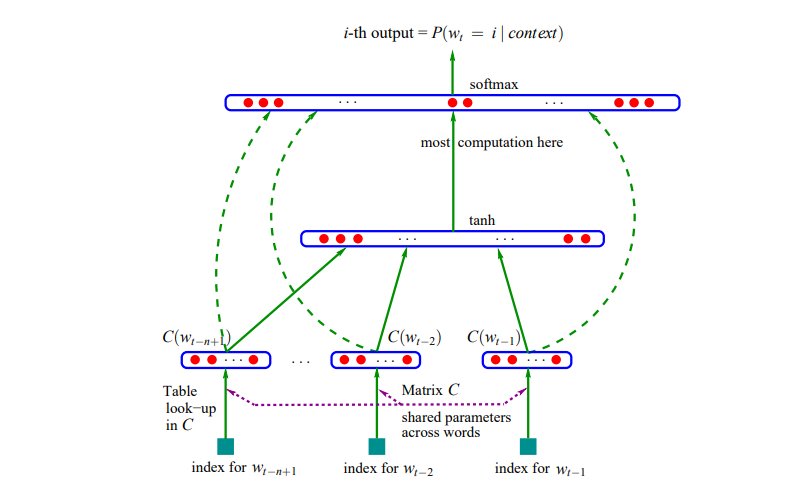

In [15]:
C[X]

tensor([[[-1.0522,  0.2530],
         [-1.0522,  0.2530],
         [-1.0522,  0.2530]],

        [[-1.0522,  0.2530],
         [-1.0522,  0.2530],
         [-0.1889,  1.5595]],

        [[-1.0522,  0.2530],
         [-0.1889,  1.5595],
         [-0.8474, -0.2539]],

        [[-0.1889,  1.5595],
         [-0.8474, -0.2539],
         [-0.8474, -0.2539]],

        [[-0.8474, -0.2539],
         [-0.8474, -0.2539],
         [-0.1251, -1.2474]]])

In [16]:
C[X].shape    #as we see we retive the empedding vector 2

torch.Size([5, 3, 2])

In [17]:
X[1, 2]

tensor(5)

In [18]:
C[X][1,2]

tensor([-0.1889,  1.5595])

In [19]:
C[5]

tensor([-0.1889,  1.5595])

In [20]:
emb = C[X]
emb.shape

torch.Size([5, 3, 2])

# Implementing the hidden layer + internals of torch.Tensor: storage, views

- Construct the hidden layer which have wieghts with dim (3*2)
cos we have 2 dim and we have 3 of them and the nomber of neuruns up to us and we will put it to 100.


In [21]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

- now what we want to do is (emb @ w1 + b1) but we have the emb is stacked up in the dimensions of this input like here 
(5,3,2)
- what we will do is that we will concatenate this inputs together (3,2)



In [22]:
torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :]], 1).shape 

torch.Size([5, 6])

In [23]:
torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :]], 1) #emb have 3 dim so we telling it we want to conc at dim 1

tensor([[-1.0522,  0.2530, -1.0522,  0.2530, -1.0522,  0.2530],
        [-1.0522,  0.2530, -1.0522,  0.2530, -0.1889,  1.5595],
        [-1.0522,  0.2530, -0.1889,  1.5595, -0.8474, -0.2539],
        [-0.1889,  1.5595, -0.8474, -0.2539, -0.8474, -0.2539],
        [-0.8474, -0.2539, -0.8474, -0.2539, -0.1251, -1.2474]])

### Sol1: torch.cat(seq of tensors, dims to concatenate) but this not really efficient cos we maybe change to 4 char in the future so you need to change that

### sol2: is to use unbind(emb, 1) which will work fine just pass the emb and the index and will give you the same result as   emb[:, 0, :],emb[:, 1, :],emb[:, 2, :] then just concatenate it .

### cat() in genereal is not effecient cos it is create a whole new tensor cos there is no way to concatenate tensores by manipulate the tensores view attrbutes

In [24]:
torch.cat(torch.unbind(emb, 1), 1)        #sol 2

tensor([[-1.0522,  0.2530, -1.0522,  0.2530, -1.0522,  0.2530],
        [-1.0522,  0.2530, -1.0522,  0.2530, -0.1889,  1.5595],
        [-1.0522,  0.2530, -0.1889,  1.5595, -0.8474, -0.2539],
        [-0.1889,  1.5595, -0.8474, -0.2539, -0.8474, -0.2539],
        [-0.8474, -0.2539, -0.8474, -0.2539, -0.1251, -1.2474]])

In [25]:
torch.cat(torch.unbind(emb, 1), 1).shape        #sol 2

torch.Size([5, 6])

## Sol 3: using torch.view()
you can look at this [blog](http://blog.ezyang.com/2019/05/pytorch-internals/) it explain how .view can change some of the internals attrbutes of the view of the tensor but nothing of the store or memory being changed, copied, moved or created when we call .view()

In [26]:
emb.view(5, 6)       #gives the same result, all what happed is the (3,2) stacked up in the same row

tensor([[-1.0522,  0.2530, -1.0522,  0.2530, -1.0522,  0.2530],
        [-1.0522,  0.2530, -1.0522,  0.2530, -0.1889,  1.5595],
        [-1.0522,  0.2530, -0.1889,  1.5595, -0.8474, -0.2539],
        [-0.1889,  1.5595, -0.8474, -0.2539, -0.8474, -0.2539],
        [-0.8474, -0.2539, -0.8474, -0.2539, -0.1251, -1.2474]])

In [27]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)   #here we can change the 5 to -1 and torch will know the right no

In [28]:
h.shape

torch.Size([5, 100])

### Broadcasting happend here  with emb.view(-1, 6) @ w1 and b1
 (5, 100)
 (100)
-  what will happend is that 100 will align in the right and a fake 1 dim will be add in the left so will be (1, 100) row vector
   (5, 100)
   (1,  100)
-  will copy verically for every one of the rows of  5 and do element wise addition, same bias vector will be added to all rows of this matric

# Implementing the output layer

In [29]:
w2 = torch.randn((100, 27))  #input is 100 and out will be 27 possible char come next
b2 = torch.randn(27)

In [30]:
logits = h @ w2 + b2

In [31]:
logits.shape

torch.Size([5, 27])

# Implementing the negative log likelihood loss

In [32]:
counts = logits.exp()   # to get the fake accounts

In [33]:
prob = counts / counts.sum(1, keepdim=True)  #normalize them into probability

In [34]:
prob.shape, prob[0].sum()

(torch.Size([5, 27]), tensor(1.))

- we have Y, the letter that comes next so we want to index into the rows of prob and each row we want to pluck out the probability assigned to the correct charcter 


In [35]:
prob[torch.arange(5), Y]  #the arange for iteration and for each row we want to grap the Y column and get the char prob

tensor([4.8353e-15, 4.2591e-07, 1.7184e-04, 2.3214e-12, 3.3829e-06])

- this gives the current probability that assigned by this NN(not trained yet) to the correct char in the sequance

In [36]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [37]:
Y

tensor([ 5, 13, 13,  1,  0])

In [38]:
prob[2,13]

tensor(0.0002)

In [39]:
loss = -prob[torch.arange(5), Y].log().mean()
loss

tensor(19.1373)

# Summary of the full network

In [40]:
X.shape, Y.shape # dataset

(torch.Size([5, 3]), torch.Size([5]))

In [41]:
emb = C[X]  #(5, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)   #here we can change the 5 to -1 and torch will know the right no
logits = h @ w2 + b2
counts = logits.exp()   # to get the fake accounts
prob = counts / counts.sum(1, keepdim=True)  #normalize them into probability
loss = -prob[torch.arange(5), Y].log().mean()
loss

tensor(19.1373)

# Introducing F.cross_entropy and why
- since we are working with classification problem so we can make it more easer than writing eveything from scratch and we will use corss inrtopy for effiecinty

## Why cross intropy over implement it from scratch
- 1) when using (cross intropy) torch will not create all internediate tensors counts, iterations.... cos all this new tensors in memory and it's inefficient to run like this
- Instead torch will cluster all this operation together and have fused kernals that efficiently evalute  these exprssion, it's sort of clusterd mathimatical operations 

- 2) the backward pass can made much more effecient mathimatically and analyticlally
- 3) under the hood corss intropy can be more numerically well behaved and as an example lets: 

In [42]:
logits = torch.tensor([-2,-3, 0, 5])
counts = logits.exp()   # to get the fake accounts
prob = counts / counts.sum()  #normalize them into probability
prob


tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])

here it worked good but what if one of logits values take on more extreme value, this can happend during optimization of NN it will work fine just will get very small nomber in the counts,  but what if you got very positive logit you will get problem like this

In [43]:
logits = torch.tensor([-100,-3, 0, 100])
counts = logits.exp()   # to get the fake accounts
prob = counts / counts.sum()  #normalize them into probability
prob


tensor([0., 0., 0., nan])

In [44]:
counts

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

as you see you get nan and cos you got inf in the counts cos it's run out of range in the floating numbers that represent the counts, you rasing exp to 100 and this gives inf
### How pytorch solve this?
- if you do offset by any nomber you will get the same result because the normalization weather you add or sub,so we ok with negative no, but positive nomber will cose oveflow the floating no,  so torch intrnally  calculate  the maximum values in the logits max([-2,-3, 0, 2]) - 2 and subtract it, so the max no will be zero 

In [45]:
logits = torch.tensor([-10,-3, 0, 100]) -100
counts = logits.exp()   # to get the fake accounts
prob = counts / counts.sum()  #normalize them into probability
prob, logits


(tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]),
 tensor([-110, -103, -100,    0]))

*As* you see it **worked**

# Implementing the training loop, overfitting one batch

In [46]:
# ------------ now made respectable :) ---------------

In [47]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [48]:
for p in parameters:
    p.requires_grad = True


In [51]:

for _ in range(10):
    #the forward pass
    emb = C[X]  #(5, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   #here we can change the 5 to -1 and torch will know the right no
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    #backward pass

    for p in parameters:
      p.grad = None
    loss.backward()
    #update
    for p in parameters:
      p.data += -0.1 * p.grad
print(loss.item())

0.014223095960915089


In [56]:
logits.max(1)   #max along the first dim

torch.return_types.max(
values=tensor([15.3815, 17.1826, 18.6905, 15.9024, 15.1094], grad_fn=<MaxBackward0>),
indices=tensor([ 5, 13, 13,  1,  0]))

In [57]:
Y

tensor([ 5, 13, 13,  1,  0])

- even thought the loss is pretty good (over fitting since we trained only on the first word )but we will not reach to zero, you will find that ... will come after it more than char for the first word e will come after and for the second word o and so on so there is many possiblitits, so we will not be able to overfit and make the loss = 0

# Training on the full dataset, minibatches


- we want randoly select some portion of the data set(mini batch) then forward, backward, update on it, then iterate this mini batches

In [63]:
torch.randint(0, 5, (32, ))  #tensore from 0-5,tuple of 32 between 0-5

tensor([4, 2, 3, 2, 1, 2, 1, 3, 3, 4, 1, 0, 1, 3, 0, 4, 0, 4, 0, 3, 4, 3, 2, 2,
        2, 4, 2, 3, 1, 0, 4, 1])

cos we are dealing with mini batches the gradient quality is lower so the direction is not reliable, it's not the actual gradient direction, but it's good enough even when we only working on 32 example, soit's much better to have approximate gradient and just make more steps than evaluate the exact gradient and take fewer steps

In [122]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [123]:
#choose the best lre
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre   #start be 0.001


# Finding a good initial learning rate

In [124]:
for p in parameters:
    p.requires_grad = True

lossi = []
lri = []
for i in range(1000):
  #mini batch
    ix = torch.randint(0, X.shape[0], (32, ))  #tensore from 0-x_shape,tuple of 32 between 0-x_shape

    #the forward pass
    emb = C[X[ix]]  #only grap thos rows, we get 32 rows of x, the emb will be  (32, 3,2) 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   #here we can change the 5 to -1 and torch will know the right no
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    #backward pass

    for p in parameters:
      p.grad = None
    loss.backward()
    #update
    lr = lrs[i]
    # lr decay 10x lower
    for p in parameters:
      p.data += -lr * p.grad

    #tracking states
    lossi.append(loss.item())
    lri.append(lre[i])

print(loss.item())

7.098387241363525


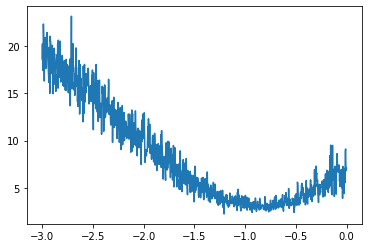

In [125]:
plt.plot(lri, lossi)  #exponent lri x, lossi y

Now we have some confident that bets lr is between -1.0 , 0.5
so we will put 10 ** -1 which 0.1 what we put at the first time


# lr decay
### training steps in general
- find decent lr using the opove approuch
- start with this lr and train for a while 
- then at end ppl like to do learning rate decay where you decay the lr by say factor of 10 and   train more steps then you get trained NN 

In [126]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [127]:
for p in parameters:
    p.requires_grad = True

lossi = []
lri = []
for i in range(10000):
  #mini batch
    ix = torch.randint(0, X.shape[0], (32, ))  #tensore from 0-x_shape,tuple of 32 between 0-x_shape

    #the forward pass
    emb = C[X[ix]]  #only grap thos rows, we get 32 rows of x, the emb will be  (32, 3,2) 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   #here we can change the 5 to -1 and torch will know the right no
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    #backward pass

    for p in parameters:
      p.grad = None
    loss.backward()
    #update
    # lr = lrs[i]
    # lr = 0.1
    lr = 0.01     # lr decay 10x lower
    for p in parameters:
      p.data += -lr * p.grad

    #tracking states
    # lossi.append(loss.item())
    # lri.append(lre[i])

print(loss.item())

2.2166988849639893


In [128]:
    #the forward pass
emb = C[X]  #only grap thos rows, we get 32 rows of x, the emb will be  (32, 3,2) 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   #here we can change the 5 to -1 and torch will know the right no
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.57037615776062


In [129]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

# Splitting up the dataset into train/val/test splits and why

- this is a very small model as we from the no of parameter it can get larger and larger if you keep adding neuruns and parameters as more the model big it becomes more amd more cabable to overfitting your dataset means that the loss might be very small as zero but all the model is doing is memorizing the data set, so if you try to smaple from that model you will get very similar examples as in the train set, no new data, and also the loss on any new names will be very high, in general it's not a good model, so we want to split the data into 3 steps
- train 80%: for optimizing the parameter, like waht we've done opove using gradient des (train parameter)
- dev 10%: developement over all the hyper parameter like the size of the hidden layer, emb size, strngth of regularization so you can try many different variation of them and see whichover one workes best on the validation data (train hyper paameter)
- test 10%: evaluate the performance of the model at the end

so we evaluating the loss on test very vew times cos every time you evaluate your test you learn somehting fom it so you also start to train on the test split so you only allowed to test the loss on the test set very very very few times otherwise you risk overfitting over it as well

In [130]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [166]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

# Experiment: larger hidden layer

In [192]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [200]:

for p in parameters:
  p.requires_grad = True
lossi = []
lri = []
stepi = []
for i in range(30000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))  #32 is the batch size
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 #if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

#print(loss.item())

In [201]:
print(loss.item())

2.58514142036438


In [202]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3837, grad_fn=<NllLossBackward0>)

this with 40000 we have to much noise this might be cos the batch size too 32
- also one other concern that we might in the hidden layer even if it's very big it could be the bottlenick of the NN the embeddings are that are 2 dim we cramming too many chars into just 2 dim and NN can't really use this space effectivly

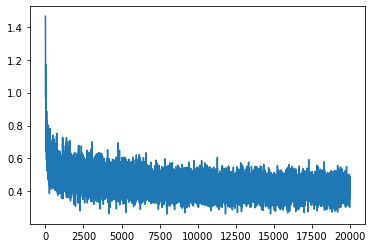

In [176]:
plt.plot(stepi, lossi)

The two loss are very close means the netwok are very tiny so we can make improvement by scalling this network by changing the neuruns to 300 or whatever u want

# Visualizing the character embeddings
- worked only with 2dim 

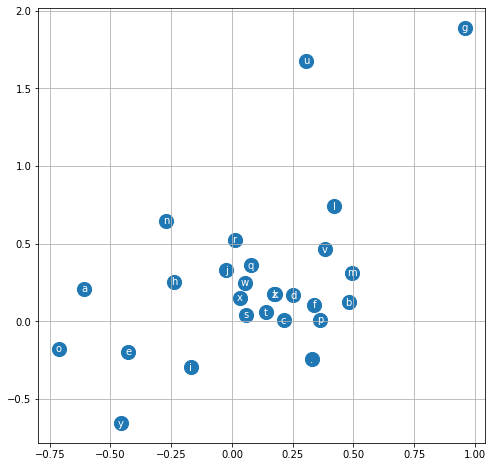

In [203]:

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


the network look like learned to separate out the char and cluster them a little like the chars aeoiy like in cluster 

# Experiment: larger embedding size
- try larger hidden layer did not give us good result so we will try larger embedding size

In [231]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)#3*10
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [232]:

for p in parameters:
  p.requires_grad = True

In [233]:
lossi = []
lri = []
stepi = []

In [234]:


for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))  #32 is the batch size
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item()) #squashes the figure

print(loss.item())

2.089254140853882


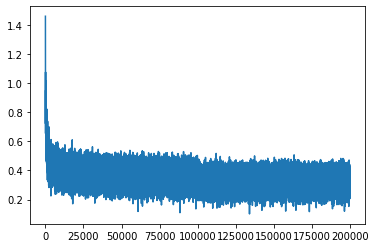

In [235]:
plt.plot(stepi, lossi)

the figure is thick cos the batch size is very small

In [236]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1654, grad_fn=<NllLossBackward0>)

# Sampling from the model

In [ ]:
context = [0] * block_size
C[torch.tensor([context])].shape


In [237]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))


carlah.
amelle.
khi.
mili.
taty.
salaysa.
jazonte.
amerynci.
aqui.
nellara.
chaiivia.
leigh.
ham.
joce.
quinn.
saline.
liveni.
wazelo.
dearysi.
jaxeunitsabee.
